In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import json
import cv2
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set paths
data_dir = Path("../data/raw/PlantVillage")

# Get all class folders
classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
print(f"Total classes found: {len(classes)}")
print("\nClasses:")
for i, cls in enumerate(classes, 1):
    print(f"{i}. {cls}")

Total classes found: 16

Classes:
1. Pepper__bell___Bacterial_spot
2. Pepper__bell___healthy
3. PlantVillage
4. Potato___Early_blight
5. Potato___Late_blight
6. Potato___healthy
7. Tomato_Bacterial_spot
8. Tomato_Early_blight
9. Tomato_Late_blight
10. Tomato_Leaf_Mold
11. Tomato_Septoria_leaf_spot
12. Tomato_Spider_mites_Two_spotted_spider_mite
13. Tomato__Target_Spot
14. Tomato__Tomato_YellowLeaf__Curl_Virus
15. Tomato__Tomato_mosaic_virus
16. Tomato_healthy


CLASS DISTRIBUTION SUMMARY
                                      Class  Image_Count  Percentage
      Tomato__Tomato_YellowLeaf__Curl_Virus         3208   15.544895
                      Tomato_Bacterial_spot         2127   10.306731
                         Tomato_Late_blight         1908    9.245530
                  Tomato_Septoria_leaf_spot         1771    8.581674
Tomato_Spider_mites_Two_spotted_spider_mite         1676    8.121335
                             Tomato_healthy         1591    7.709454
                     Pepper__bell___healthy         1478    7.161894
                        Tomato__Target_Spot         1404    6.803314
                      Potato___Early_blight         1000    4.845666
                       Potato___Late_blight         1000    4.845666
                        Tomato_Early_blight         1000    4.845666
              Pepper__bell___Bacterial_spot          997    4.831129
                           Tomato_Leaf_Mold          952    4.613074
       

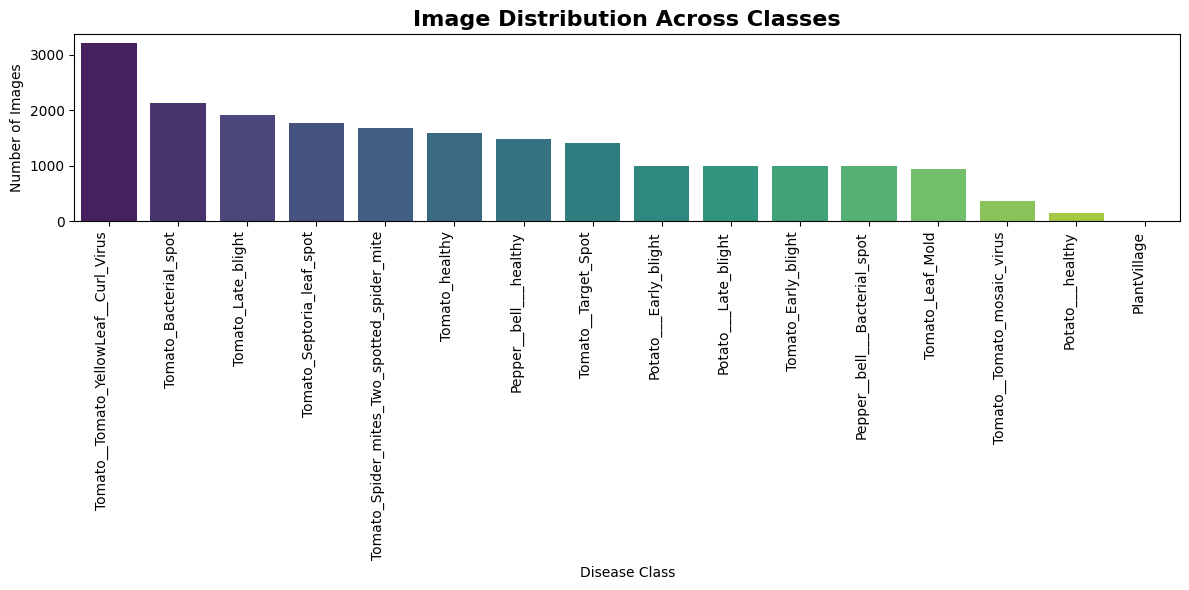


Class Imbalance Ratio: inf
⚠️ WARNING: Significant class imbalance detected!
   Consider using class weights during training


In [4]:
# Count images per class
class_counts = {}
all_image_paths = []

for class_name in classes:
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG")) + \
             list(class_path.glob("*.png")) + list(class_path.glob("*.PNG"))
    class_counts[class_name] = len(images)
    all_image_paths.extend(images)

# Image data summary
df_distribution = pd.DataFrame({
    'Class': list(class_counts.keys()),
    'Image_Count': list(class_counts.values())
})

df_distribution['Percentage'] = (df_distribution['Image_Count'] / df_distribution['Image_Count'].sum()) * 100
df_distribution = df_distribution.sort_values('Image_Count', ascending=False)

print("CLASS DISTRIBUTION SUMMARY")
print(df_distribution.to_string(index=False))
print(f"\nTotal Images: {df_distribution['Image_Count'].sum()}")
print(f"Min images per class: {df_distribution['Image_Count'].min()}")
print(f"Max images per class: {df_distribution['Image_Count'].max()}")
print(f"Mean images per class: {df_distribution['Image_Count'].mean():.2f}")
print(f"Std Dev: {df_distribution['Image_Count'].std():.2f}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=df_distribution, x='Class', y='Image_Count', palette='viridis')
plt.xticks(rotation=90, ha='right')
plt.title('Image Distribution Across Classes', fontsize=16, fontweight='bold')
plt.xlabel('Disease Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.savefig('../data/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for severe class imbalance
max_count = df_distribution['Image_Count'].max()
min_count = df_distribution['Image_Count'].min()
imbalance_ratio = max_count / min_count
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠️ WARNING: Significant class imbalance detected!")
    print("   Consider using class weights during training")
else:
    print("✓ Classes are reasonably balanced")


Analyzing image properties...

IMAGE PROPERTIES SUMMARY
       width  height  channels  file_size_kb
count  500.0   500.0     500.0    500.000000
mean   256.0   256.0       3.0     16.466523
std      0.0     0.0       0.0      4.293074
min    256.0   256.0       3.0      3.359375
25%    256.0   256.0       3.0     13.545410
50%    256.0   256.0       3.0     16.746582
75%    256.0   256.0       3.0     19.558594
max    256.0   256.0       3.0     26.862305

IMAGE FORMATS
JPEG    500
Name: count, dtype: int64

COLOR MODES
RGB    500
Name: count, dtype: int64

ANOMALY DETECTION

✓ No corrupted images found


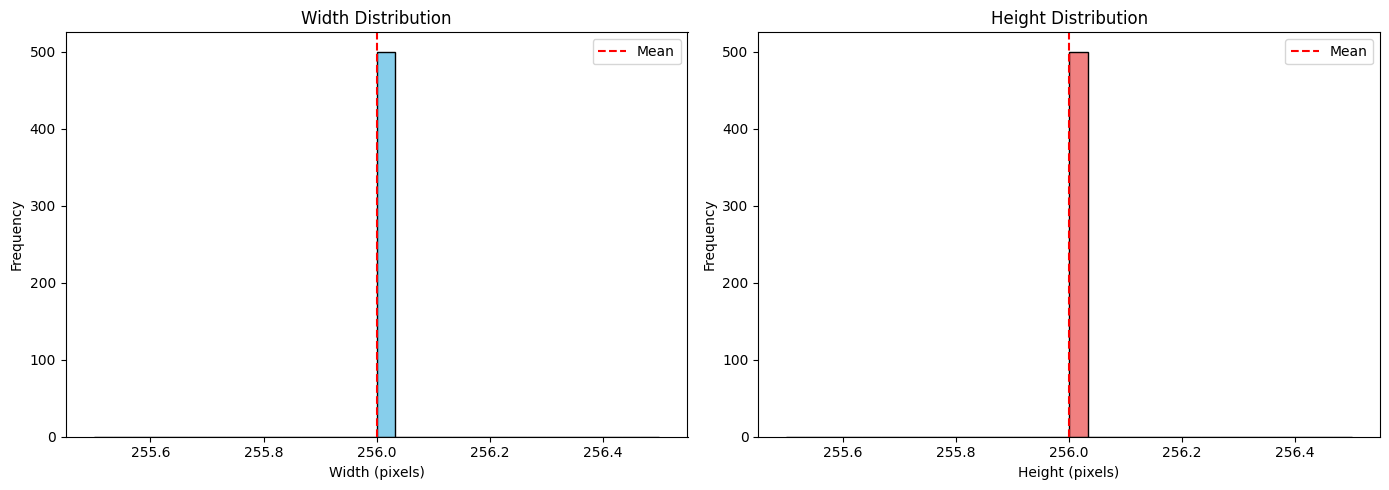

In [5]:
# Sample images to analyze properties
sample_size = min(500, len(all_image_paths))
sample_images = np.random.choice(all_image_paths, sample_size, replace=False)

image_properties = {
    'width': [],
    'height': [],
    'channels': [],
    'file_size_kb': [],
    'format': [],
    'mode': []
}

corrupted_images = []

print("\nAnalyzing image properties...")
for img_path in sample_images:
    try:
        img = Image.open(img_path)
        image_properties['width'].append(img.width)
        image_properties['height'].append(img.height)
        image_properties['mode'].append(img.mode)
        image_properties['format'].append(img.format)
        
        # Count channels
        if img.mode == 'RGB':
            image_properties['channels'].append(3)
        elif img.mode == 'L':
            image_properties['channels'].append(1)
        elif img.mode == 'RGBA':
            image_properties['channels'].append(4)
        else:
            image_properties['channels'].append(len(img.getbands()))
        
        # File size
        file_size = os.path.getsize(img_path) / 1024  # KB
        image_properties['file_size_kb'].append(file_size)
        
        img.close()
    except Exception as e:
        corrupted_images.append((str(img_path), str(e)))
        print(f"❌ Error reading {img_path}: {e}")

# Create summary DataFrame
df_properties = pd.DataFrame(image_properties)

print("\nIMAGE PROPERTIES SUMMARY")
print(df_properties.describe())

print("\nIMAGE FORMATS")
print(pd.Series(image_properties['format']).value_counts())

print("\nCOLOR MODES")
print(pd.Series(image_properties['mode']).value_counts())

# Check for anomalies
print("\nANOMALY DETECTION")

# Unusual dimensions
unusual_width = df_properties[
    (df_properties['width'] < 50) | (df_properties['width'] > 5000)
]
unusual_height = df_properties[
    (df_properties['height'] < 50) | (df_properties['height'] > 5000)
]

if len(unusual_width) > 0:
    print(f"⚠️ Found {len(unusual_width)} images with unusual widths")
if len(unusual_height) > 0:
    print(f"⚠️ Found {len(unusual_height)} images with unusual heights")

# Corrupted images
if corrupted_images:
    print(f"\n Found {len(corrupted_images)} corrupted images:")
    for path, error in corrupted_images:
        print(f"   - {path}: {error}")
else:
    print("\n✓ No corrupted images found")

# Visualize dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(image_properties['width'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Width Distribution')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(image_properties['width']), color='red', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(image_properties['height'], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Height Distribution')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(image_properties['height']), color='red', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/image_dimensions.png', dpi=300)
plt.show()


ASPECT RATIO ANALYSIS
Mean aspect ratio: 1.000
Std aspect ratio: 0.000
Min aspect ratio: 1.000
Max aspect ratio: 1.000
✓ Aspect ratios are very consistent


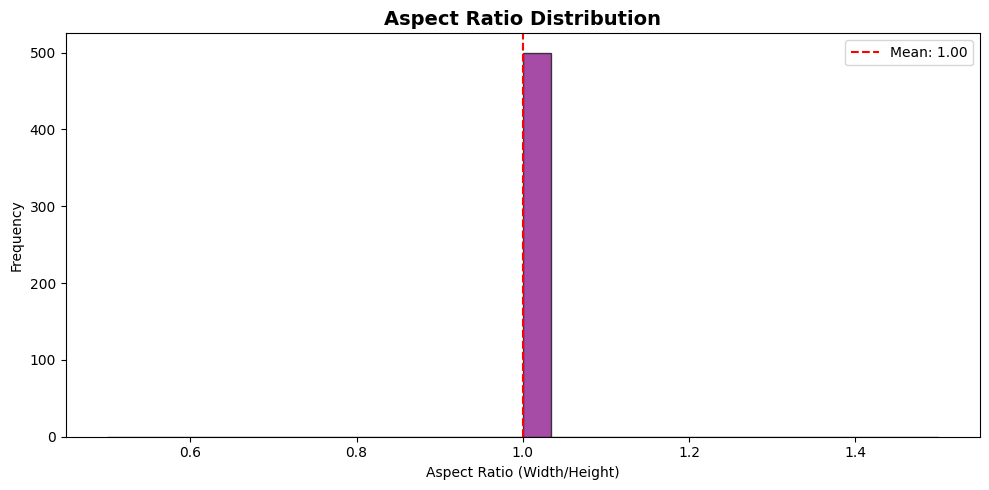

In [9]:
# Calculate aspect ratios
aspect_ratios = []
for w, h in zip(image_properties['width'], image_properties['height']):
    aspect_ratios.append(w / h)

df_properties['aspect_ratio'] = aspect_ratios

print("\nASPECT RATIO ANALYSIS")
print(f"Mean aspect ratio: {np.mean(aspect_ratios):.3f}")
print(f"Std aspect ratio: {np.std(aspect_ratios):.3f}")
print(f"Min aspect ratio: {np.min(aspect_ratios):.3f}")
print(f"Max aspect ratio: {np.max(aspect_ratios):.3f}")

# Check for consistency
if np.std(aspect_ratios) < 0.1:
    print("✓ Aspect ratios are very consistent")
elif np.std(aspect_ratios) < 0.3:
    print("⚠️ Moderate aspect ratio variation")
else:
    print("⚠️ High aspect ratio variation - consider padding instead of stretching")

# Visualize aspect ratio distribution
plt.figure(figsize=(10, 5))
plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
plt.title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('../data/aspect_ratio_distribution.png', dpi=300)
plt.show()

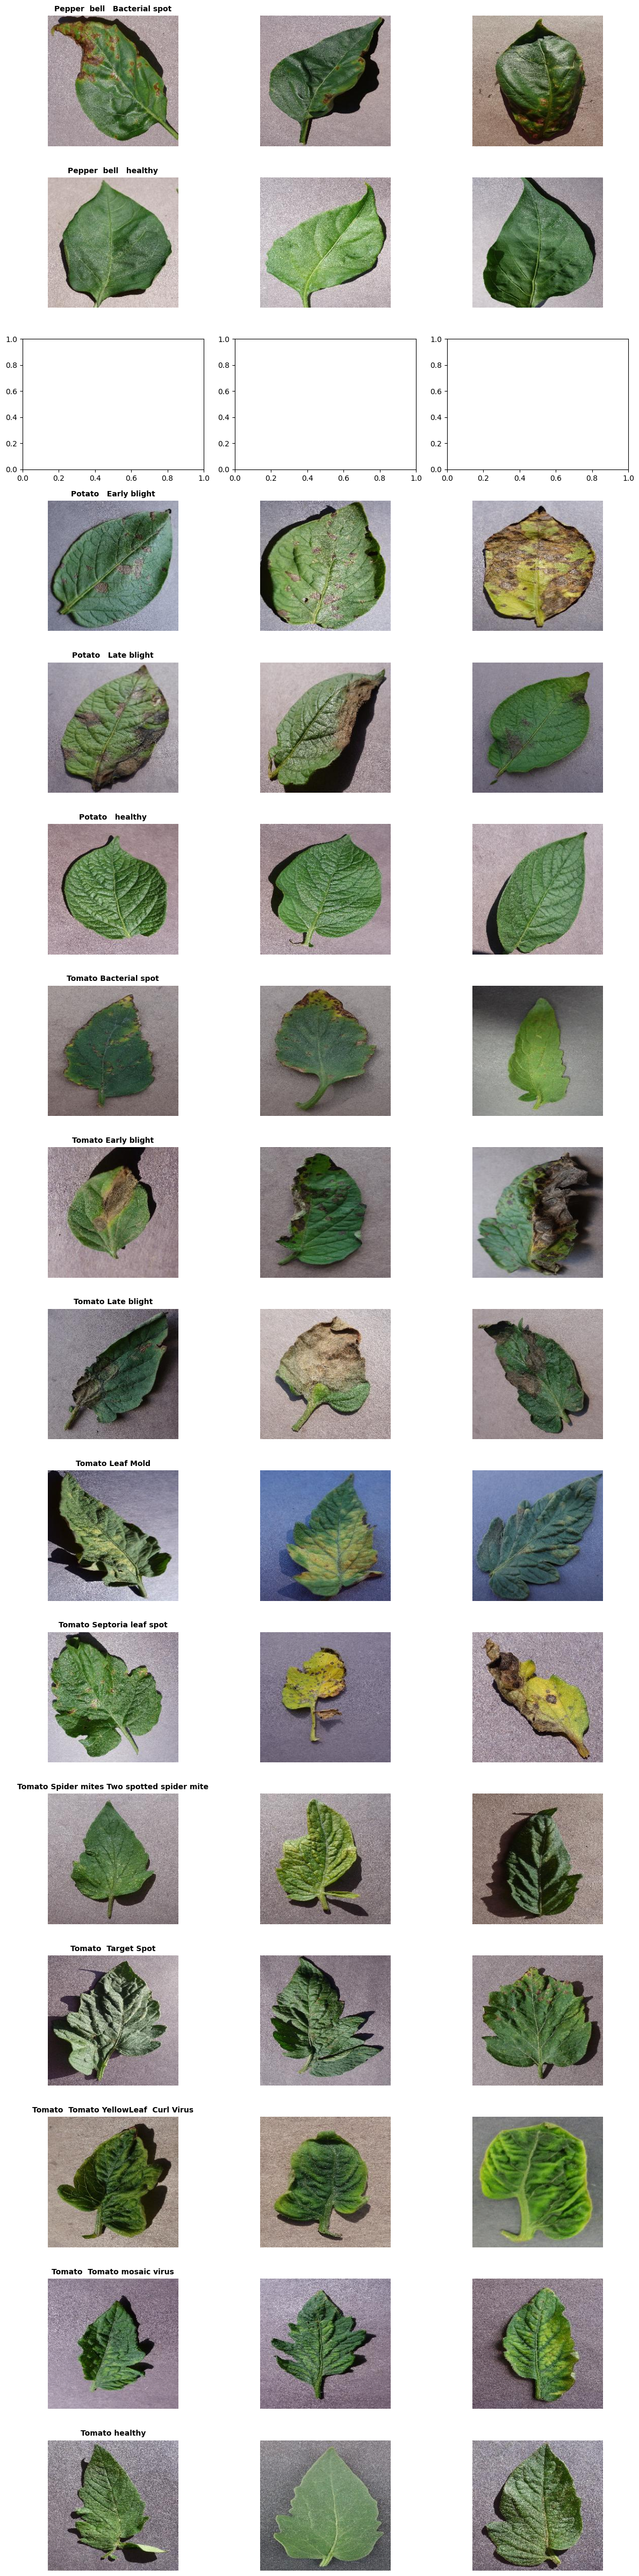

In [6]:
# Display sample images from each class
n_samples = 3
n_classes = len(classes)

fig, axes = plt.subplots(n_classes, n_samples, figsize=(12, n_classes * 3))

for i, class_name in enumerate(classes):
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG"))
    
    sample_imgs = np.random.choice(images, min(n_samples, len(images)), replace=False)
    
    for j, img_path in enumerate(sample_imgs):
        try:
            img = Image.open(img_path)
            if n_classes == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name.replace('_', ' '), fontsize=10, fontweight='bold')
            img.close()
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")

plt.tight_layout()
plt.savefig('../data/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

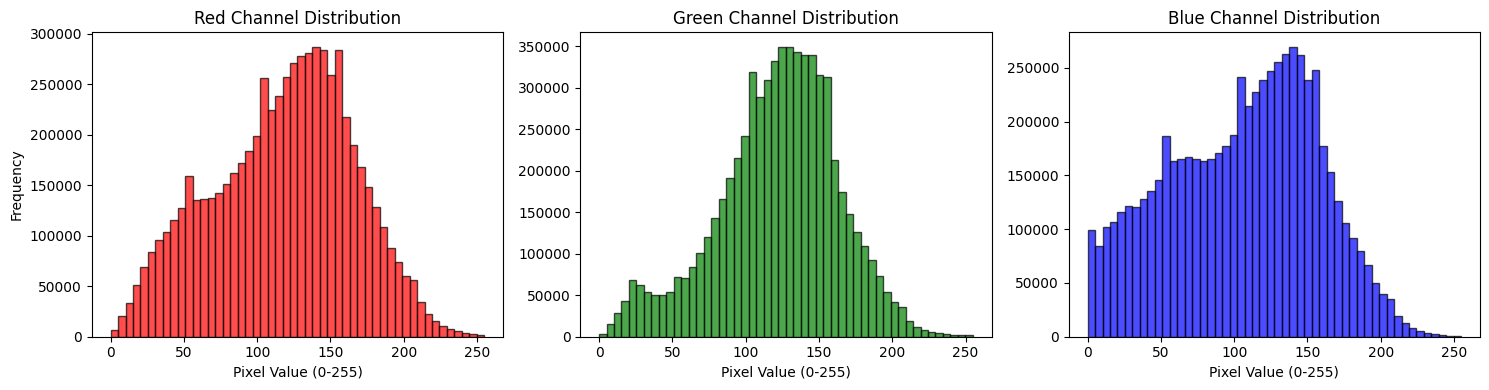


Red Channel - Mean: 117.81, Std: 47.77
Green Channel - Mean: 121.74, Std: 41.21
Blue Channel - Mean: 105.50, Std: 50.98


In [7]:
# Analyze pixel value distribution
sample_for_intensity = np.random.choice(all_image_paths, min(100, len(all_image_paths)), replace=False)

red_values = []
green_values = []
blue_values = []

for img_path in sample_for_intensity:
    try:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        red_values.extend(img_array[:, :, 0].flatten())
        green_values.extend(img_array[:, :, 1].flatten())
        blue_values.extend(img_array[:, :, 2].flatten())
        
        img.close()
    except Exception as e:
        print(f"Error: {e}")

# Plot pixel distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(red_values, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Red Channel Distribution')
axes[0].set_xlabel('Pixel Value (0-255)')
axes[0].set_ylabel('Frequency')

axes[1].hist(green_values, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Green Channel Distribution')
axes[1].set_xlabel('Pixel Value (0-255)')

axes[2].hist(blue_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_title('Blue Channel Distribution')
axes[2].set_xlabel('Pixel Value (0-255)')

plt.tight_layout()
plt.savefig('../data/pixel_distribution.png', dpi=300)
plt.show()

print(f"\nRed Channel - Mean: {np.mean(red_values):.2f}, Std: {np.std(red_values):.2f}")
print(f"Green Channel - Mean: {np.mean(green_values):.2f}, Std: {np.std(green_values):.2f}")
print(f"Blue Channel - Mean: {np.mean(blue_values):.2f}, Std: {np.std(blue_values):.2f}")

COLOR CHANNEL CORRELATION ANALYSIS

Color Channel Correlation Matrix:
            Red     Green      Blue
Red    1.000000  0.913166  0.889926
Green  0.913166  1.000000  0.749376
Blue   0.889926  0.749376  1.000000

Correlation Interpretation:
Red-Green: 0.913 → Strong correlation (channels carry similar info)
Red-Blue: 0.890 → Strong correlation (channels carry similar info)
Green-Blue: 0.749 → Moderate correlation


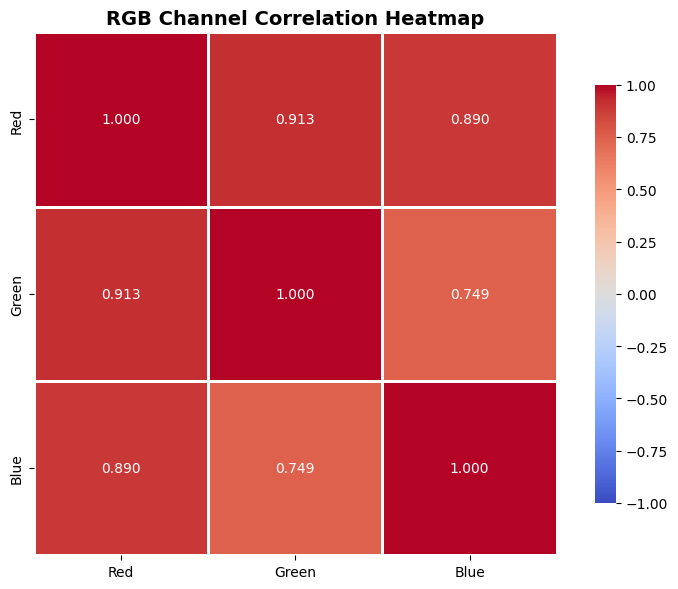

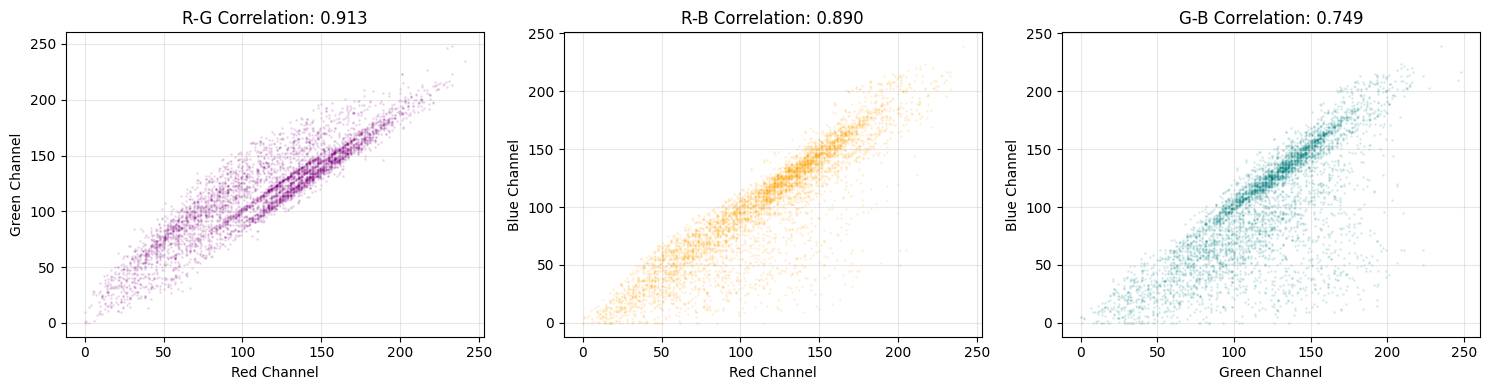


✓ Color correlation analysis complete!
  Analyzed 33,800 pixel samples from 50 images


In [10]:
# Color channel correlation analysis
print("COLOR CHANNEL CORRELATION ANALYSIS")

# Sample fewer images for correlation analysis (memory efficient)
sample_for_correlation = np.random.choice(all_image_paths, min(50, len(all_image_paths)), replace=False)

# Collect pixel values for correlation
r_vals = []
g_vals = []
b_vals = []

for img_path in sample_for_correlation:
    try:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)
        
        # Subsample pixels (every 10th pixel to reduce memory)
        r_vals.extend(img_array[::10, ::10, 0].flatten())
        g_vals.extend(img_array[::10, ::10, 1].flatten())
        b_vals.extend(img_array[::10, ::10, 2].flatten())
        
        img.close()
    except Exception as e:
        print(f"Error: {e}")

# Create correlation matrix
color_data = pd.DataFrame({
    'Red': r_vals,
    'Green': g_vals,
    'Blue': b_vals
})

correlation_matrix = color_data.corr()

print("\nColor Channel Correlation Matrix:")
print(correlation_matrix)

# Interpret correlations
print("\nCorrelation Interpretation:")
for i, ch1 in enumerate(['Red', 'Green', 'Blue']):
    for j, ch2 in enumerate(['Red', 'Green', 'Blue']):
        if i < j:
            corr_val = correlation_matrix.iloc[i, j]
            print(f"{ch1}-{ch2}: {corr_val:.3f}", end=" → ")
            if abs(corr_val) > 0.8:
                print("Strong correlation (channels carry similar info)")
            elif abs(corr_val) > 0.5:
                print("Moderate correlation")
            else:
                print("Weak correlation (channels are independent)")

# Visualize correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, fmt='.3f')
plt.title('RGB Channel Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/color_correlation.png', dpi=300)
plt.show()

# Scatter plots for channel relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Subsample for plotting (too many points slow down visualization)
plot_sample = np.random.choice(len(r_vals), min(5000, len(r_vals)), replace=False)

axes[0].scatter(np.array(r_vals)[plot_sample], np.array(g_vals)[plot_sample], 
                alpha=0.1, s=1, c='purple')
axes[0].set_xlabel('Red Channel')
axes[0].set_ylabel('Green Channel')
axes[0].set_title(f'R-G Correlation: {correlation_matrix.iloc[0, 1]:.3f}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(np.array(r_vals)[plot_sample], np.array(b_vals)[plot_sample], 
                alpha=0.1, s=1, c='orange')
axes[1].set_xlabel('Red Channel')
axes[1].set_ylabel('Blue Channel')
axes[1].set_title(f'R-B Correlation: {correlation_matrix.iloc[0, 2]:.3f}')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(np.array(g_vals)[plot_sample], np.array(b_vals)[plot_sample], 
                alpha=0.1, s=1, c='teal')
axes[2].set_xlabel('Green Channel')
axes[2].set_ylabel('Blue Channel')
axes[2].set_title(f'G-B Correlation: {correlation_matrix.iloc[1, 2]:.3f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/channel_scatter_plots.png', dpi=300)
plt.show()

print("\n✓ Color correlation analysis complete!")
print(f"  Analyzed {len(r_vals):,} pixel samples from {len(sample_for_correlation)} images")


Analyzing: Pepper__bell___Bacterial_spot

Analyzing: Pepper__bell___healthy

Analyzing: PlantVillage
  No images found, skipping.

Analyzing: Potato___Early_blight

Analyzing: Potato___Late_blight

Analyzing: Potato___healthy

Analyzing: Tomato_Bacterial_spot

Analyzing: Tomato_Early_blight

Analyzing: Tomato_Late_blight

Analyzing: Tomato_Leaf_Mold

Analyzing: Tomato_Septoria_leaf_spot

Analyzing: Tomato_Spider_mites_Two_spotted_spider_mite

Analyzing: Tomato__Target_Spot

Analyzing: Tomato__Tomato_YellowLeaf__Curl_Virus

Analyzing: Tomato__Tomato_mosaic_virus

Analyzing: Tomato_healthy


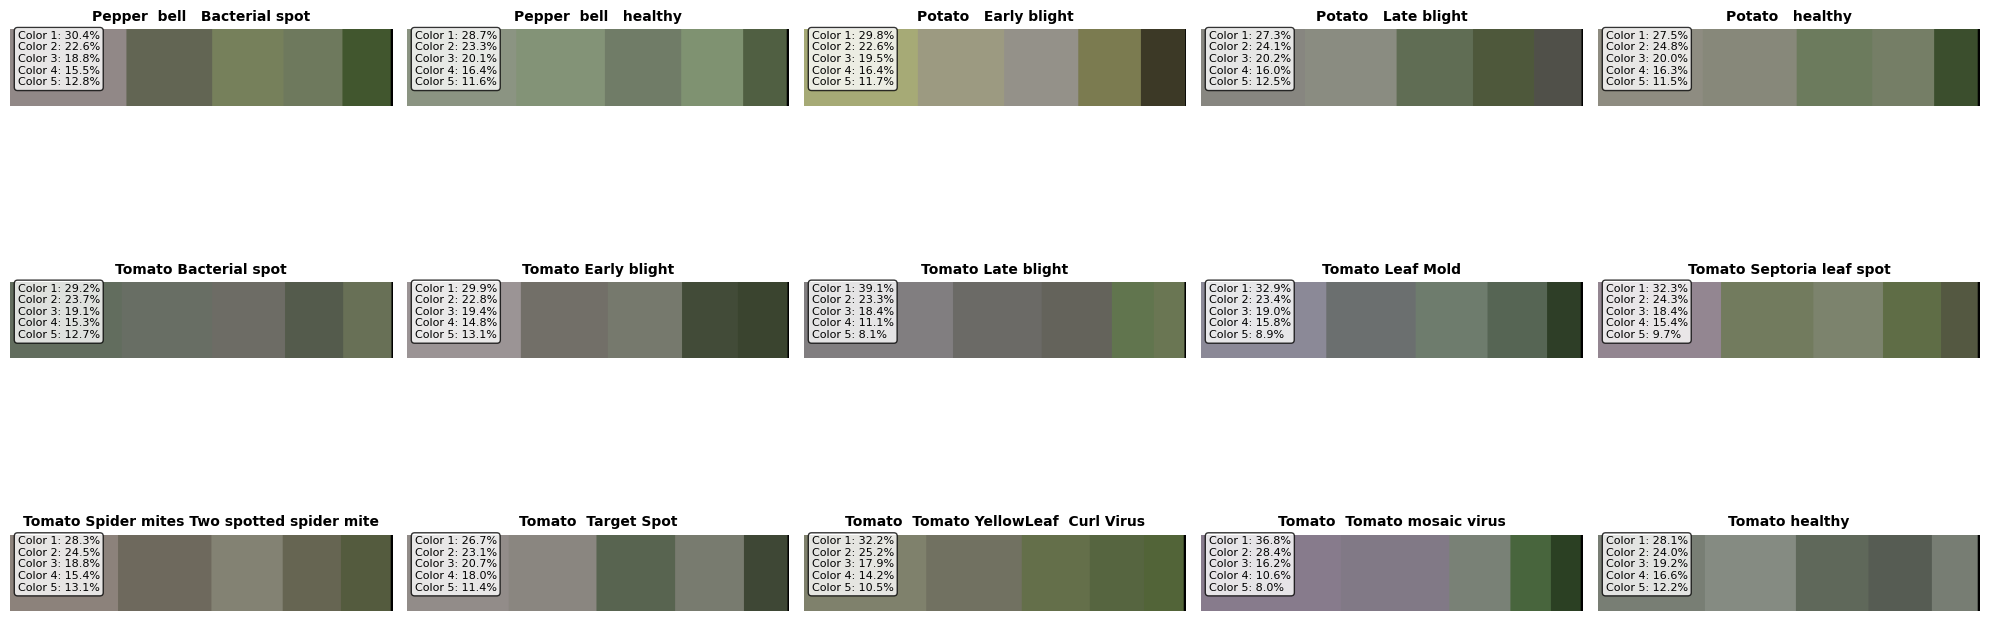


✓ Dominant color extraction complete!


In [18]:
def extract_dominant_colors(image_path, n_colors=5):
    """Extract n dominant colors from an image using K-means clustering"""
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(img)
    
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # Calculate percentage of each color
    label_counts = Counter(labels)
    total_pixels = len(labels)
    percentages = [(label_counts[i] / total_pixels) * 100 for i in range(n_colors)]
    
    # Sort by percentage
    sorted_indices = np.argsort(percentages)[::-1]
    colors = colors[sorted_indices]
    percentages = [float(percentages[i]) for i in sorted_indices]
    
    return colors, percentages

# Extract dominant colors for each class
dominant_colors_per_class = {}
n_samples_per_class = 10
n_dominant_colors = 5

for class_name in classes:
    print(f"\nAnalyzing: {class_name}")
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG"))
    
    if len(images) == 0:
        print(f"  No images found, skipping.")
        continue
    
    sample_imgs = np.random.choice(images, min(n_samples_per_class, len(images)), replace=False)
    
    all_colors = []
    all_percentages = []
    
    for img_path in sample_imgs:
        try:
            colors, percentages = extract_dominant_colors(img_path, n_dominant_colors)
            all_colors.append(colors)
            all_percentages.append(percentages)
        except Exception as e:
            print(f"  Error processing {img_path}: {e}")
    
    if len(all_colors) == 0:
        print(f"  All images failed, skipping.")
        continue
    
    avg_colors = np.mean(np.array(all_colors), axis=0)  # Shape: (5, 3)
    avg_percentages = np.mean(np.array(all_percentages), axis=0)  # Shape: (5,)
    
    dominant_colors_per_class[class_name] = {
        'colors': avg_colors,
        'percentages': avg_percentages
    }

# Visualize dominant colors for each class
n_classes_found = len(dominant_colors_per_class)
n_cols = 5
n_rows = (n_classes_found + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for idx, (class_name, data) in enumerate(dominant_colors_per_class.items()):
    ax = axes[idx]
    cls_colors = np.array(data['colors'])    # Ensure (5, 3) shape
    cls_pcts = np.array(data['percentages']) # Ensure (5,) shape
    
    # Create color palette strip
    color_palette = np.zeros((100, 500, 3))
    x_start = 0
    
    for i in range(len(cls_pcts)):
        x_end = x_start + int(cls_pcts[i] * 5)
        color_palette[:, x_start:x_end] = cls_colors[i] / 255.0
        x_start = x_end
    
    ax.imshow(color_palette)
    ax.axis('off')
    ax.set_title(f"{class_name.replace('_', ' ')}", fontsize=10, fontweight='bold')
    
    # Add color percentages as text
    text_str = '\n'.join([f"Color {i+1}: {cls_pcts[i]:.1f}%" for i in range(len(cls_pcts))])
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Hide unused subplots
for idx in range(n_classes_found, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../data/dominant_colors_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Dominant color extraction complete!")

Processing: Pepper__bell___Bacterial_spot
Processing: Pepper__bell___healthy
Processing: PlantVillage
Processing: Potato___Early_blight
Processing: Potato___Late_blight
Processing: Potato___healthy
Processing: Tomato_Bacterial_spot
Processing: Tomato_Early_blight
Processing: Tomato_Late_blight
Processing: Tomato_Leaf_Mold
Processing: Tomato_Septoria_leaf_spot
Processing: Tomato_Spider_mites_Two_spotted_spider_mite
Processing: Tomato__Target_Spot
Processing: Tomato__Tomato_YellowLeaf__Curl_Virus
Processing: Tomato__Tomato_mosaic_virus
Processing: Tomato_healthy


TypeError: 'numpy.float64' object is not iterable

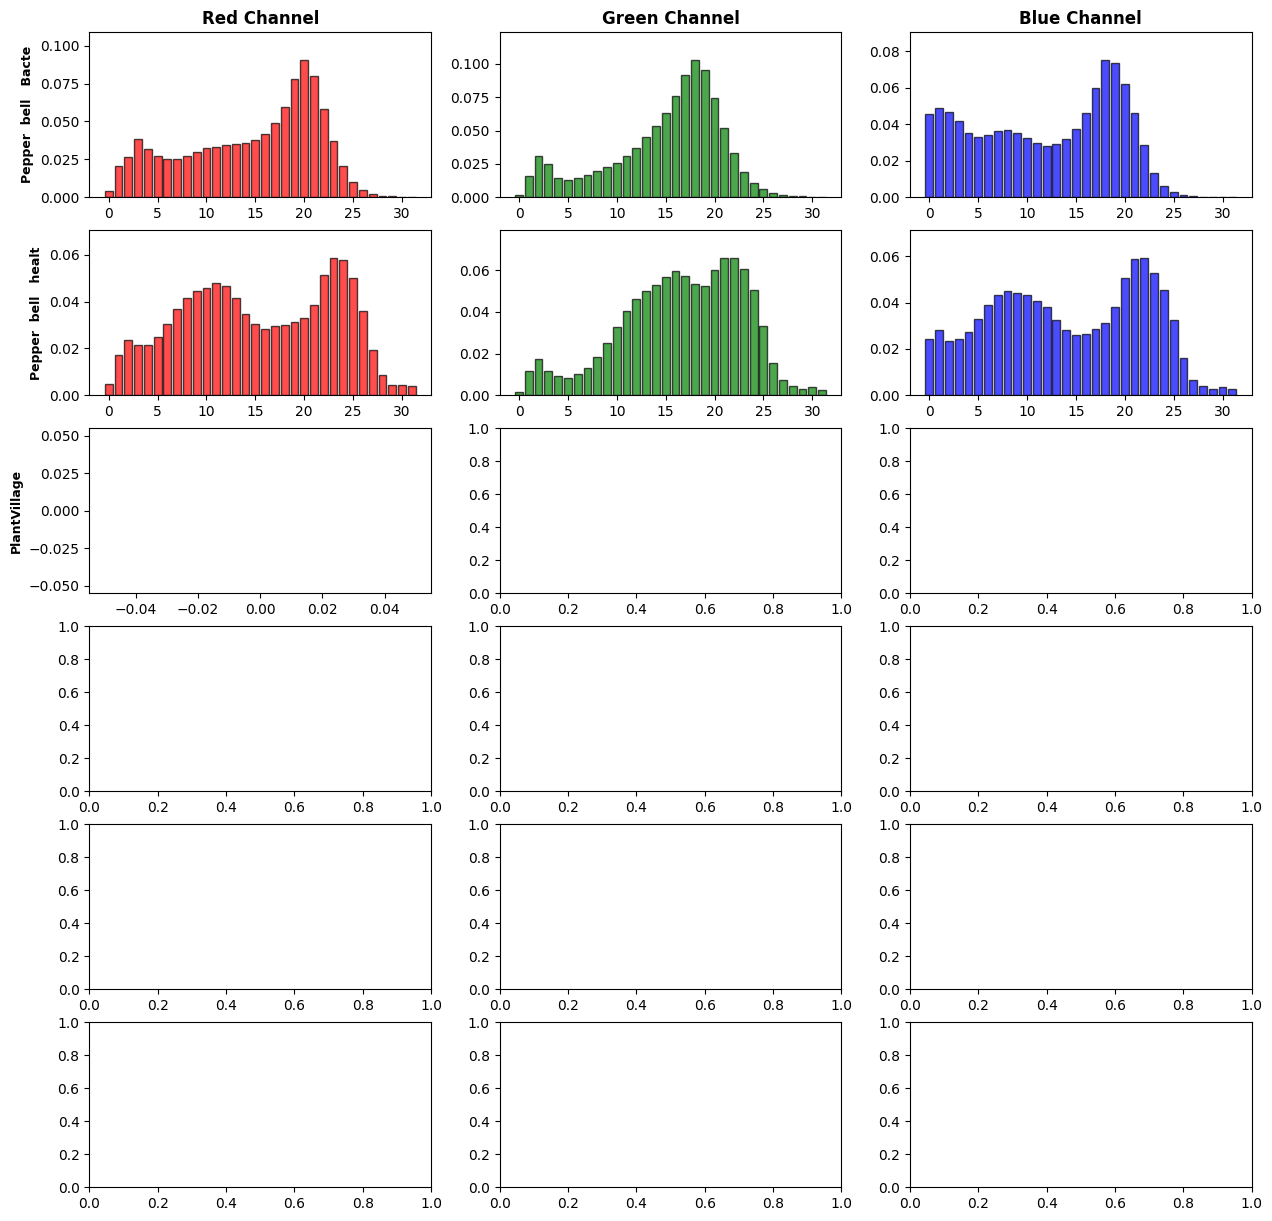

In [ ]:
def compute_color_histogram(image_path, bins=32):
    """Compute normalized RGB histogram for an image"""
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    
    hist_r, _ = np.histogram(img_array[:, :, 0], bins=bins, range=(0, 256))
    hist_g, _ = np.histogram(img_array[:, :, 1], bins=bins, range=(0, 256))
    hist_b, _ = np.histogram(img_array[:, :, 2], bins=bins, range=(0, 256))
    
    # Normalize
    total_pixels = img_array.shape[0] * img_array.shape[1]
    hist_r = hist_r / total_pixels
    hist_g = hist_g / total_pixels
    hist_b = hist_b / total_pixels
    
    return hist_r, hist_g, hist_b

# Compute average histograms per class
n_samples_hist = 20
histogram_data = {}

for class_name in classes:
    class_path = data_dir / class_name
    images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.JPG"))
    
    if len(images) == 0:
        print(f"Skipping {class_name} (no images)")
        continue
    
    print(f"Processing: {class_name}")
    sample_imgs = np.random.choice(images, min(n_samples_hist, len(images)), replace=False)
    
    r_hists = []
    g_hists = []
    b_hists = []
    
    for img_path in sample_imgs:
        try:
            hist_r, hist_g, hist_b = compute_color_histogram(img_path)
            r_hists.append(hist_r)
            g_hists.append(hist_g)
            b_hists.append(hist_b)
        except Exception as e:
            print(f"  Error: {e}")
    
    if len(r_hists) == 0:
        continue
    
    # Average histograms
    histogram_data[class_name] = {
        'red': np.mean(r_hists, axis=0),
        'green': np.mean(g_hists, axis=0),
        'blue': np.mean(b_hists, axis=0)
    }

# Visualize comparison (show subset if too many classes)
max_classes_to_show = 6
valid_classes = list(histogram_data.keys())
classes_to_show = valid_classes[:max_classes_to_show] if len(valid_classes) > max_classes_to_show else valid_classes

fig, axes = plt.subplots(len(classes_to_show), 3, figsize=(15, len(classes_to_show) * 2.5))

if len(classes_to_show) == 1:
    axes = axes.reshape(1, -1)

for idx, class_name in enumerate(classes_to_show):
    data = histogram_data[class_name]
    
    # Red channel
    axes[idx, 0].bar(range(32), data['red'], color='red', alpha=0.7, edgecolor='black')
    axes[idx, 0].set_ylabel(class_name.replace('_', ' ')[:20], fontsize=9, fontweight='bold')
    axes[idx, 0].set_ylim(0, np.max(data['red']) * 1.2)
    if idx == 0:
        axes[idx, 0].set_title('Red Channel', fontweight='bold')
    if idx == len(classes_to_show) - 1:
        axes[idx, 0].set_xlabel('Bin')
    
    # Green channel
    axes[idx, 1].bar(range(32), data['green'], color='green', alpha=0.7, edgecolor='black')
    axes[idx, 1].set_ylim(0, np.max(data['green']) * 1.2)
    if idx == 0:
        axes[idx, 1].set_title('Green Channel', fontweight='bold')
    if idx == len(classes_to_show) - 1:
        axes[idx, 1].set_xlabel('Bin')
    
    # Blue channel
    axes[idx, 2].bar(range(32), data['blue'], color='blue', alpha=0.7, edgecolor='black')
    axes[idx, 2].set_ylim(0, np.max(data['blue']) * 1.2)
    if idx == 0:
        axes[idx, 2].set_title('Blue Channel', fontweight='bold')
    if idx == len(classes_to_show) - 1:
        axes[idx, 2].set_xlabel('Bin')

plt.tight_layout()
plt.savefig('../data/color_histogram_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison
print("\n" + "="*60)
print("HISTOGRAM STATISTICS")
print("="*60)

for class_name, data in histogram_data.items():
    r_peak = np.argmax(data['red']) * 8  # Convert bin to pixel value
    g_peak = np.argmax(data['green']) * 8
    b_peak = np.argmax(data['blue']) * 8
    
    print(f"\n{class_name}:")
    print(f"  Red peak at: {r_peak} | Green peak at: {g_peak} | Blue peak at: {b_peak}")
    print(f"  R entropy: {-np.sum(data['red'] * np.log(data['red'] + 1e-10)):.3f}")
    print(f"  G entropy: {-np.sum(data['green'] * np.log(data['green'] + 1e-10)):.3f}")
    print(f"  B entropy: {-np.sum(data['blue'] * np.log(data['blue'] + 1e-10)):.3f}")

print("\n✓ Color histogram comparison complete!")

In [8]:
# Save exploration results
metadata = {
    'total_images': int(df_distribution['Image_Count'].sum()),
    'num_classes': len(classes),
    'classes': classes,
    'class_distribution': df_distribution.to_dict('records'),
    'image_properties': {
        'mean_width': float(np.mean(image_properties['width'])),
        'mean_height': float(np.mean(image_properties['height'])),
        'std_width': float(np.std(image_properties['width'])),
        'std_height': float(np.std(image_properties['height'])),
        'mean_aspect_ratio': float(np.mean(aspect_ratios)),
        'std_aspect_ratio': float(np.std(aspect_ratios)),
        'common_format': pd.Series(image_properties['format']).mode()[0],
        'common_mode': pd.Series(image_properties['mode']).mode()[0]
    },
    'corrupted_images': corrupted_images,
    'imbalance_ratio': float(imbalance_ratio),
    'recommended_target_size': [224, 224],  # Standard for transfer learning
    'normalization_method': 'rescale_1_255'  # Will divide by 255
}

# Save to JSON
with open('../data/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)